# Spec2Vec - test ability to match unkown spectra to similar ones

In [1]:
# Locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_SPEC2VEC = ROOT + "\\Spec2Vec\\code\\"
PATH_MS_DATA = ROOT + "\\Data\\GNPS_all\\"
PATH_SAVE_MODEL = ROOT + "\\Spec2Vec\\models_trained\\"
PATH_COMPUTED = ROOT + "\\Spec2Vec\\computed_results\\"
PATH_OUTPUT = ROOT + "\\Spec2Vec\\output_plots\\"

In [2]:
import numpy as np
import sys
sys.path.insert(0, PATH_SPEC2VEC)

import helper_functions as functions
import MS_functions

### Load filtered allGNPS_positive dataset OR:  Import& filter allGNPS_positive dataset

In [3]:
file_json = PATH_MS_DATA + "allGNPS_positive_minmax_10_1000_2dec_exp08_191115.json"
file_mgf = ROOT + "\\Data\\GNPS_all\\" + "allGNPS_positive_191106.mgf"

spectra, spectra_dict, MS_documents, MS_documents_intensity, spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [4]:
spectra_metadata.head()

,doc_ID,gnps_ID,name,title,precursor_mz,num_peaks_losses,inchi,inchikey,smiles,charge
0,0,CCMSLIB00005435503,chenodeoxycholic acid M-H2O+H,NaN,375.290,93,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-GYHJSIKNSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
1,1,CCMSLIB00005435504,chenodeoxycholic acid 2M+H,NaN,785.593,101,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-PODLAYBOSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
2,2,CCMSLIB00005435505,chenodeoxycholic acid 2M+Na,NaN,807.575,21,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-PODLAYBOSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
3,3,CCMSLIB00005435506,cholic acid M+Na,NaN,431.277,35,"""InChI=1S/C24H40O5/c1-13(4-7-21(28)29)16-5-6-1...",BHQCQFFYRZLCQQ-IHELEQLESA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1
4,4,CCMSLIB00005435507,deoxycholic acid M-H2O+H,NaN,375.289,157,"""InChI=1S/C24H40O4/c1-14(4-9-22(27)28)18-7-8-1...",KXGVEGMKQFWNSR-BKAWJTANSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1


### Get metadata from benchmarking subset

In [5]:
file_json = PATH_MS_DATA + "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191116.json"
file_mgf = []

_,_,_,_, spectra_metadata_uniqueinchikey_positive = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0, #0.1,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [6]:
benchmarking_gnpsIDs = spectra_metadata_uniqueinchikey_positive['gnps_ID'].values.copy()
benchmarking_gnpsIDs.shape

(10998,)

In [7]:
benchmarking_gnpsIDs[:10]

array(['CCMSLIB00005435506', 'CCMSLIB00005435507', 'CCMSLIB00005435517',
       'CCMSLIB00005435523', 'CCMSLIB00005435528', 'CCMSLIB00005435529',
       'CCMSLIB00005435532', 'CCMSLIB00005435537', 'CCMSLIB00005435545',
       'CCMSLIB00005435547'], dtype=object)

### Shuffle gnps IDs

In [8]:
np.random.seed(42) # to make it reproducible
np.random.shuffle(benchmarking_gnpsIDs)

In [9]:
benchmarking_gnpsIDs[:10]

array(['CCMSLIB00000579646', 'CCMSLIB00000850303', 'CCMSLIB00000856170',
       'CCMSLIB00000845612', 'CCMSLIB00000079847', 'CCMSLIB00000845821',
       'CCMSLIB00000079739', 'CCMSLIB00000854639', 'CCMSLIB00000846422',
       'CCMSLIB00000205344'], dtype=object)

In [16]:
all_gnpsIDs = spectra_metadata['gnps_ID'].values
all_gnpsIDs.shape

(90226,)

In [39]:
from similarity_measure import SimilarityMeasures

remove_parts = [100, 250, 500, 1000, 2000, 5000, 10998, 0]

for remove_part in remove_parts:
    # Remove some benchmarking spectra from corpus
    #keepIDs = [x for x in range(len(MS_documents)) if all_gnpsIDs[x] not in benchmarking_gnpsIDs[:remove_part]]
    #MS_documents_removedpart = MS_documents[keepIDs].copy()
    MS_documents_removedpart = [MS_documents[x] for x in range(len(MS_documents)) if all_gnpsIDs[x] not in benchmarking_gnpsIDs[:remove_part]]   
    print("Modified corpus consists of", len(MS_documents_removedpart), "documents.")
    
    MS_measure = SimilarityMeasures(MS_documents_removedpart)
    MS_measure.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
    print("Number of unique words: ", len(MS_measure.dictionary))
    
    # Train new model based on reduced corpus
    file_model_word2vec = PATH_SAVE_MODEL + 'S2V_allGNPS_pos_removed' + str(remove_part) + '_d300_w500_neg5_minmax10_1000_dec2_exp08.model'
    MS_measure.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                                 min_count=1, workers=4, iterations= [10,5], 
                                 use_stored_model=True)
    

Modified corpus consits of 90126 documents.
Preprocess documents...
Number of unique words:  145584
Stored word2vec model not found!
Calculating new word2vec model...
 Epoch 1 of 15.Change in loss after epoch 1: 6971581.0
 Epoch 2 of 15.Change in loss after epoch 2: 5166913.0
 Epoch 3 of 15.Change in loss after epoch 3: 4632233.0
 Epoch 4 of 15.Change in loss after epoch 4: 3625171.0
 Epoch 5 of 15.Change in loss after epoch 5: 3407310.0
 Epoch 6 of 15.Change in loss after epoch 6: 3345366.0
 Epoch 7 of 15.Change in loss after epoch 7: 3198742.0
 Epoch 8 of 15.Change in loss after epoch 8: 2980270.0
 Epoch 9 of 15.Change in loss after epoch 9: 1940046.0
 Epoch 10 of 15.Change in loss after epoch 10: 1731692.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Spec2Vec\models_trained\S2V_allGNPS_pos_removed100_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_10.model
 Epoch 11 of 15.Change in loss after epoch 11: 1634108.0
 Epoch 12 of 15.Change in l

Modified corpus consits of 79228 documents.
Preprocess documents...
Number of unique words:  145429
Stored word2vec model not found!
Calculating new word2vec model...
 Epoch 1 of 15.Change in loss after epoch 1: 5749354.5
 Epoch 2 of 15.Change in loss after epoch 2: 4289110.5
 Epoch 3 of 15.Change in loss after epoch 3: 3740872.0
 Epoch 4 of 15.Change in loss after epoch 4: 3495593.0
 Epoch 5 of 15.Change in loss after epoch 5: 2807822.0
 Epoch 6 of 15.Change in loss after epoch 6: 2749188.0
 Epoch 7 of 15.Change in loss after epoch 7: 2560624.0
 Epoch 8 of 15.Change in loss after epoch 8: 2458572.0
 Epoch 9 of 15.Change in loss after epoch 9: 2400662.0
 Epoch 10 of 15.Change in loss after epoch 10: 2305122.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Spec2Vec\models_trained\S2V_allGNPS_pos_removed10998_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_10.model
 Epoch 11 of 15.Change in loss after epoch 11: 1684708.0
 Epoch 12 of 15.Change in

In [33]:
benchmarking_gnpsIDs[10997] in benchmarking_gnpsIDs[:10998]

True

In [40]:
def get_similarities_removed_parts(remove_parts, filenames, save_matrix, save_refscore):
    # Run routine for all saved models
    ref_score_Spec2Vec_tests_lst = []
    for i, filename in enumerate(filenames):
        MS_measure.build_model_word2vec(filename, size=300, window=500, 
                                 min_count=1, workers=4, iterations=1, 
                                 use_stored_model=True)

        MS_measure.get_vectors_centroid(method = 'ignore', #'update',
                                 extra_weights = MS_documents_intensity, 
                                 tfidf_weighted = False,
                                 weight_method = 'sqrt', 
                                 tfidf_model = None,
                                 extra_epochs = 5)

        M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')
        np.save(PATH_COMPUTED + save_matrix + str(remove_parts[i]) + '_191118.npy', M_sim_ctr)

        A = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
        A = np.delete(A.reshape(length**2), remove_diagonal)

        # Plot against dice score on morgan3 fingerprints   
        ref_score_Spec2Vec = plot_precentile(A, B, num_bins = 1000 , show_top_percentile = 0.5)
        ref_score_Spec2Vec_tests_lst.append(ref_score_Spec2Vec)
        np.save(PATH_COMPUTED + save_refscore + str(remove_parts[i]) + '_morgan3_dice.npy', ref_score_Spec2Vec) 
        
    return ref_score_Spec2Vec_tests_lst

In [42]:
file_json = PATH_MS_DATA + "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191116.json"
file_mgf = ROOT + "\\Data\\GNPS_all\\" + "allGNPS_positive_uniqueInchikey_191107.mgf"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0, #0.1,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [43]:
from similarity_measure import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)
MS_measure.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  116344


In [48]:
import MS_similarity_classical as MS_sim_classic

filename = PATH_COMPUTED + 'M_mol_sim_uniqueInchikey_pos_191110_morgan3_dice.npy'
M_sim_mol = MS_sim_classic.mol_sim_matrix([], #fingerprints_morgan3_2048,
                                       [], #fingerprints_morgan3_2048,
                                       method = 'dice',
                                       filename = filename)

Molecular similarity scores found and loaded.


In [49]:
# Find bette way to keep track of wrong fingerprints!!
exclude_IDs = [1435, 1440, 2232, 2233, 9384, 10791, 10991]

In [50]:
# Transform molecular similarity matrix in 1D array AND remove all excluded IDs
B = np.delete(np.delete(M_sim_mol, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = B.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
B = np.delete(B.reshape(length**2), remove_diagonal)

In [58]:
from plotting_functions import plot_precentile

ref_score_cum_modcos_minmatch14 = np.load(PATH_COMPUTED + 'spec2vec_uniquesmiles_pos_ModCos_min_match_14.npy')

Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.documents. of  10998  documents.1720  of  10998  documents. documents. 10998  documents.3030  of  10998  documents. 10998  documents. 10998  documents. 4800  of  10998  documents. 10998  documents.10998  documents. of  10998  documents. documents. 6170  of  10998  documents. 6230  of  10998  documents.  of  10998  documents. 10998  documents.6610  of  10998  documents.7630  of  10998  documents.8260  of  10998  documents. of  10998  documents. of  10998  documents. 10090  of  10998  documents.  of  10998  documents. of  10998  documents.Load stored word2vec model ...
Not all 'words' of the given documents are present in the trained word2vec model!
1  out of  116344  'words' were not found in the word2vec model.
'Words'missing in the pretrained word2vec model will be ignored.
Removing missing 'words' from corpus...
  C

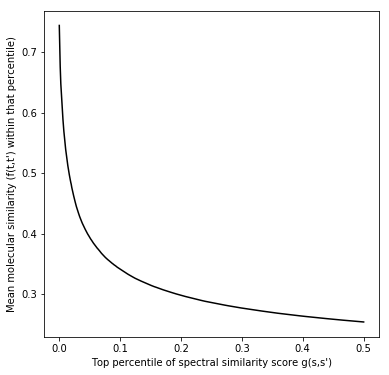

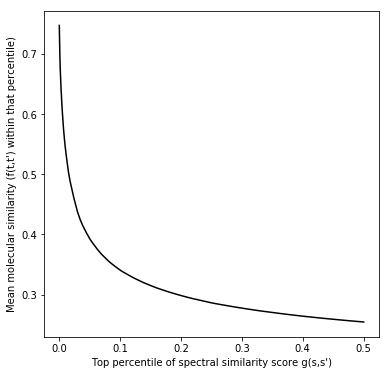

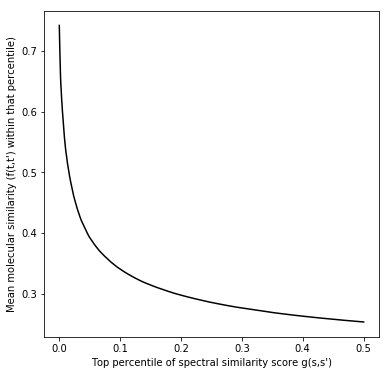

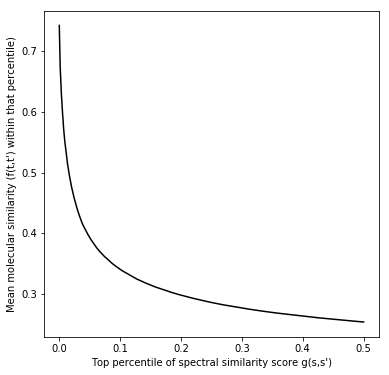

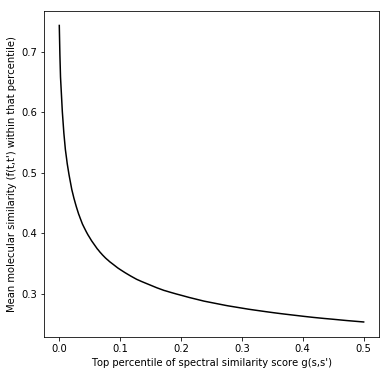

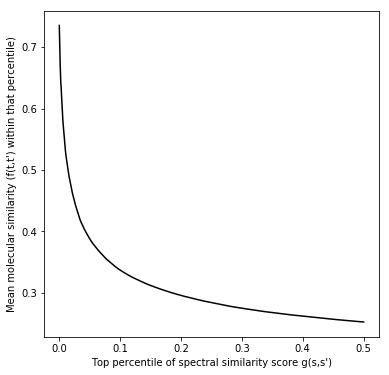

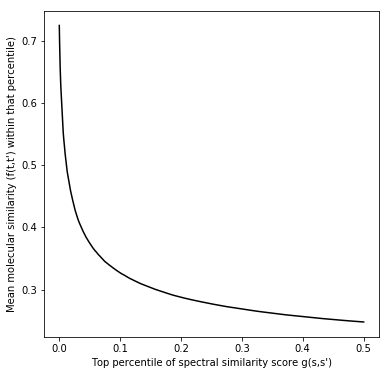

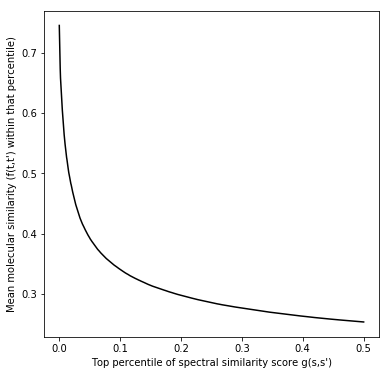

In [53]:
from scipy import spatial
remove_parts = [100, 250, 500, 1000, 2000, 5000, 10998, 0]

filenames = []
for remove_part in remove_parts:   
    # Load model trained on reduced corpus
    filenames.append(PATH_SAVE_MODEL + 'S2V_allGNPS_pos_removed' + str(remove_part) + '_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_15.model')
    
ref_score_Spec2Vec_tests_lst = get_similarities_removed_parts(remove_parts,
                                    filenames, 
                                    save_matrix = 'M_sim_allGNPS_pos_d300_w500_minmax10_1000_dec2_exp08_iter_15_removed', 
                                    save_refscore = 'ref_score_allGNPS_pos_d300_w500_minmax10_1000_dec2_exp08_iter_15_removed')        
    

In [76]:
MS_measure.model_word2vec.negative

5

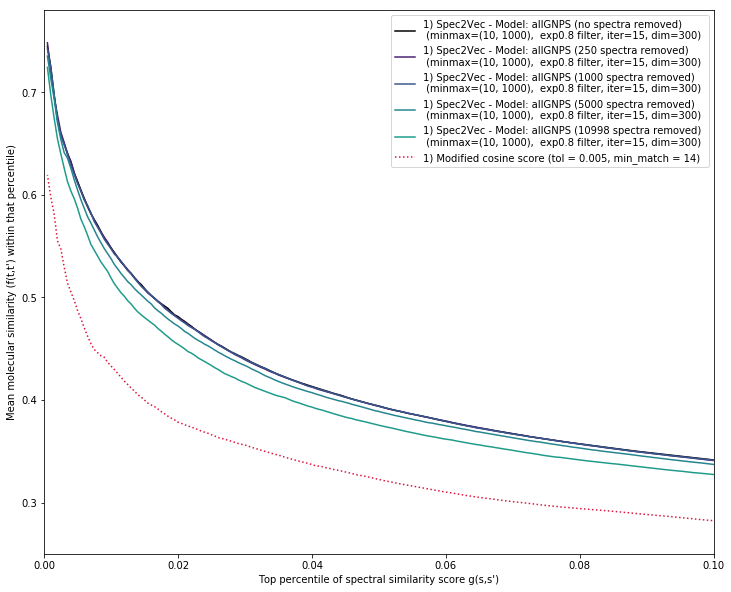

In [69]:
from matplotlib import pyplot as plt
import matplotlib

# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(12,10))
cmap = matplotlib.cm.get_cmap('viridis') #'Spectral')

selectedpairs = [(x, remove_parts[x]) for x in [1,3,5,6]]
count = 1

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst[7], 
             color= 'black',
             label= str(count) + ') Spec2Vec - Model: allGNPS (no spectra removed) \n (minmax=(10, 1000),  exp0.8 filter, iter=15, dim=300)')

for i, remove_part in selectedpairs:
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst[i], 
             color= cmap(i/11), 
             label= str(count) + ') Spec2Vec - Model: allGNPS (' + str(remove_part) + ' spectra removed) \n (minmax=(10, 1000),  exp0.8 filter, iter=15, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         ':', color='crimson', #'gold', #'crimson',
         label= str(count) + ') Modified cosine score (tol = 0.005, min_match = 14)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig(PATH_OUTPUT + 'Top_percentile_testing_removing_spectra_191118.pdf')

Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.00  of  10998  documents.10998  documents. 10998  documents.  of  10998  documents.  of  10998  documents.3780  of  10998  documents.10998  documents. documents. 10998  documents.7750  of  10998  documents.  of  10998  documents.  of  10998  documents. documents. 10998  documents. Calculated centroid vectors for  8740  of  10998  documents. of  10998  documents. of  10998  documents. 9670  of  10998  documents. of  10998  documents. 10998  documents.10998  documents.Load stored word2vec model ...
Not all 'words' of the given documents are present in the trained word2vec model!
1  out of  116344  'words' were not found in the word2vec model.
'Words'missing in the pretrained word2vec model will be ignored.
Removing missing 'words' from corpus...
  Calculated centroid vectors for  10998  of  10998  documents.of  10998  d

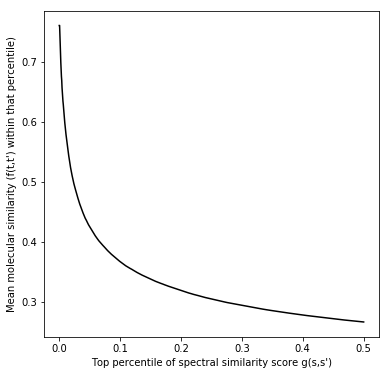

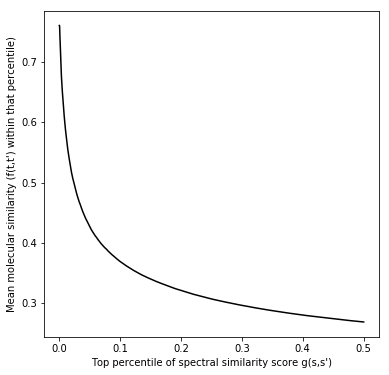

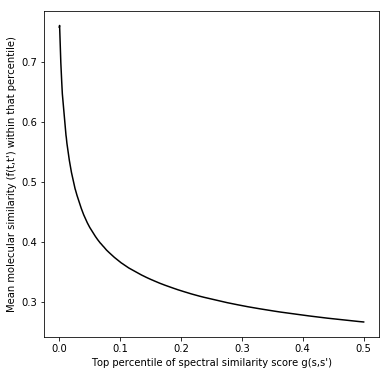

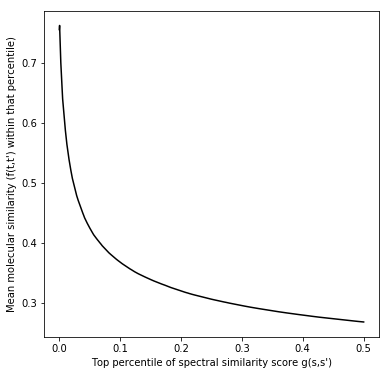

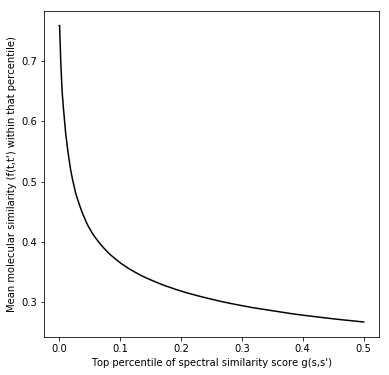

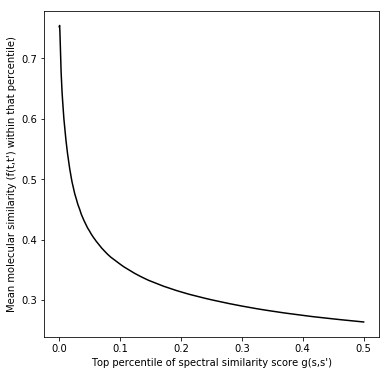

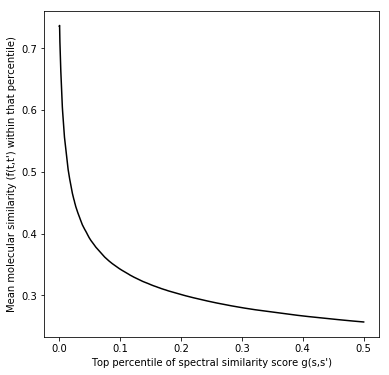

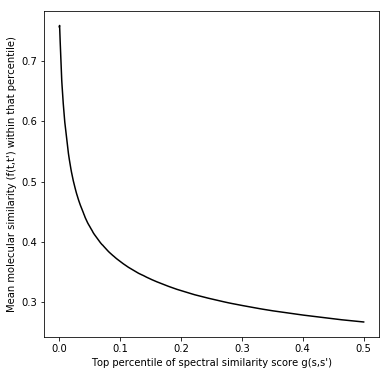

In [75]:
from scipy import spatial
remove_parts = [100, 250, 500, 1000, 2000, 5000, 10998, 0]

filenames = []
for remove_part in remove_parts:   
    # Load model trained on reduced corpus
    filenames.append(PATH_SAVE_MODEL + 'S2V_allGNPS_pos_removed' + str(remove_part) + '_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_10.model')
    
ref_score_Spec2Vec_tests_iter10_lst = get_similarities_removed_parts(remove_parts,
                                    filenames, 
                                    save_matrix = 'M_sim_allGNPS_pos_d300_w500_minmax10_1000_dec2_exp08_iter_10_removed', 
                                    save_refscore = 'ref_score_allGNPS_pos_d300_w500_minmax10_1000_dec2_exp08_iter_10_removed')        
    

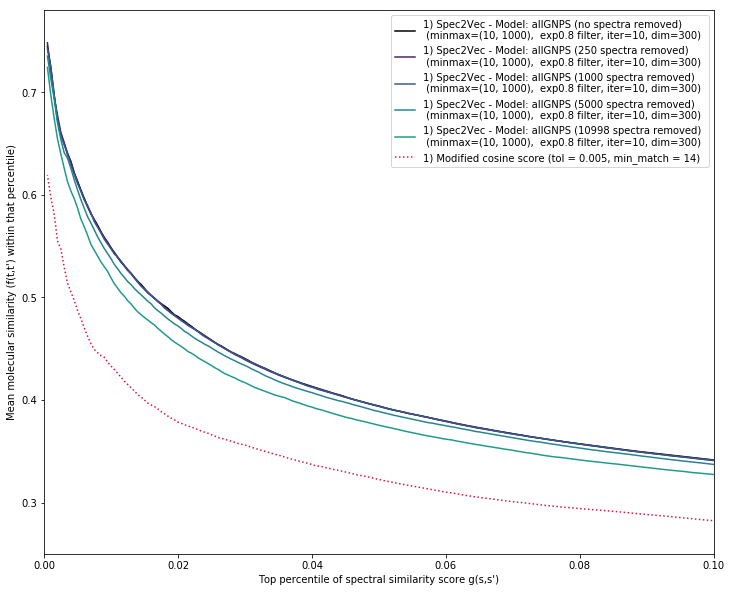

In [77]:
from matplotlib import pyplot as plt
import matplotlib

# Compare all:
num_bins = 1000
show_top_percentile = 0.5

fig, ax = plt.subplots(figsize=(12,10))
cmap = matplotlib.cm.get_cmap('viridis') #'Spectral')

selectedpairs = [(x, remove_parts[x]) for x in [1,3,5,6]]
count = 1

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst[7], 
             color= 'black',
             label= str(count) + ') Spec2Vec - Model: allGNPS (no spectra removed) \n (minmax=(10, 1000),  exp0.8 filter, iter=10, dim=300)')

for i, remove_part in selectedpairs:
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst[i], 
             color= cmap(i/11), 
             label= str(count) + ') Spec2Vec - Model: allGNPS (' + str(remove_part) + ' spectra removed) \n (minmax=(10, 1000),  exp0.8 filter, iter=10, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         ':', color='crimson', #'gold', #'crimson',
         label= str(count) + ') Modified cosine score (tol = 0.005, min_match = 14)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.78)
plt.savefig(PATH_OUTPUT + 'Top_percentile_testing_removing_spectra_iter10_191118.pdf')